# Inverse problem formulation for shear wave velocity estimation

In [40]:
import os
os.environ['PATH'] = "/home/riascodc/DelftOpenSource/bin:" + os.environ['PATH']

import matplotlib.pyplot as plt
import segyio
import obspy
import pickle 
from matplotlib import colors
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from scipy.interpolate import RegularGridInterpolator, CubicSpline
import numpy as np
from matplotlib.colors import Normalize
from numpy.polynomial import Polynomial
import colorcet as cc
from scipy.signal import ricker, convolve, correlate
from celluloid import Camera
from scipy.stats import linregress

import pylops

path = './Data'
os.system(f'cd {path}')

from scipy.integrate import cumulative_trapezoid

In [41]:
x_model = 80
y_model = 40
dx = 0.25

nx, nz = int(x_model//dx)+1, int(y_model//dx)+1

snap_vz = segyio.su.open('/home/riascodc/Documents/ARF/Code/Data/bodysnap_svz.su', endian='little', ignore_geometry=True)
snap_vz = segyio.collect(snap_vz.trace)[:].flatten()

nsnap = snap_vz.size // (nx*nz)
snap_vz = snap_vz.reshape(nsnap, nx, nz)

snap_vx = segyio.su.open('/home/riascodc/Documents/ARF/Code/Data/bodysnap_svx.su', endian='little', ignore_geometry=True)
snap_vx = segyio.collect(snap_vx.trace)[:].flatten()
snap_vx = snap_vx.reshape(nsnap, nx, nz)

# SNAPSHOT PARAMETERS
tsnap1 = 0.01
tsnap2 = 0.8
dtsnap = 0.001

time = np.arange(0, tsnap2+dtsnap, dtsnap)
time.shape, snap_vz.shape


((801,), (801, 321, 161))

In [42]:
# Integrate over time for each spatial point
disp_x = cumulative_trapezoid(snap_vx, dx=dtsnap, axis=0, initial=0)
disp_z = cumulative_trapezoid(snap_vz, dx=dtsnap, axis=0, initial=0)
total_disp = (disp_x**2 + disp_z**2)**(1/2)

disp_z.max(), snap_vz.max(), disp_x.max()

(0.012666317, 0.48893335, 0.004385386)

In [43]:
# Load the data back from the file
with open('1000scatts.pkl', 'rb') as file:
    data_loaded = pickle.load(file)

# Assign variables from the loaded dictionary
window = data_loaded['window']
num_scatterers = data_loaded['num_scatterers']
scatterers = data_loaded['scatterers']
scatterer_amplitudes = data_loaded['scatterer_amplitudes']
scatterer_history = data_loaded['scatterer_history']

time_axs = np.linspace(0, disp_x.shape[0]*dtsnap, disp_x.shape[0])
time_axs_inst = time_axs[1:]  

# Sensors location 
num_receivers = 20
beamwidth = 2
receiver_positions = np.linspace(window[0]*dx + beamwidth/2, window[1]*dx - beamwidth/2, num_receivers)

# Naive inversion on theoretical vertical displacement

We solve for $\mu$ by doing:

$$\mu(x, z)=\rho \frac{1}{N} \sum_{n=1}^N \frac{\left(\frac{\partial^2 u_z}{\partial t^2}\right)_{x, z}}{\left(\frac{\partial^2 u_z}{\partial x^2}+\frac{\partial^2 u_z}{\partial z^2}\right)_{t=n T}}$$

However this result is very unstable given the division over the laplacian. 

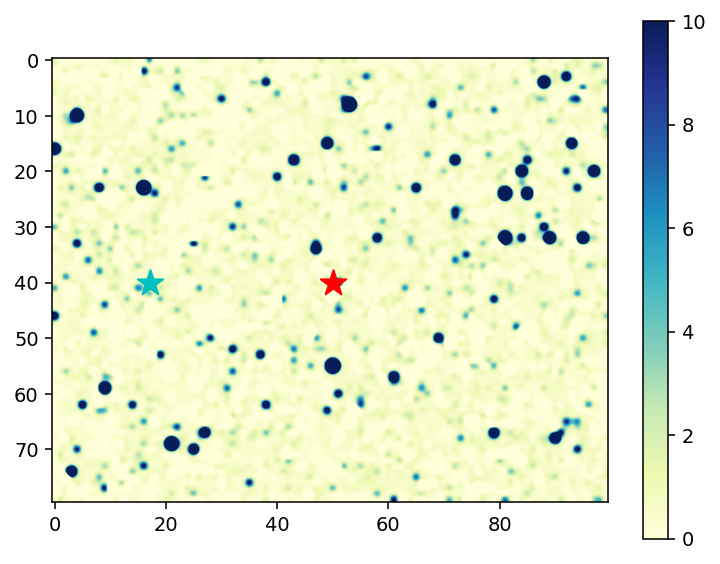

In [44]:
def cumsum_in_windows(matrix, n):
    """
    Performs a cumulative sum over windows of length n in the time dimension, creating an undersampled matrix.
    
    Parameters:
    - matrix: np.array, the original matrix with dimensions [time, x, z].
    - n: int, the window length for the cumulative sum.
    
    Returns:
    - undersampled_matrix: np.array, an undersampled matrix with each element being the sum over a window of size n,
                           with dimensions [time_undersampled, x, z].
    """
    # Initialize an empty list to hold the cumsum results for each window
    window_cumsums = []
    
    # Iterate over the matrix in windows of size n
    for i in range(0, matrix.shape[0], n):
        # Ensure we don't go out of bounds in the final window
        end_index = i + n if (i + n) <= matrix.shape[0] else matrix.shape[0]
        
        # Calculate the cumsum for the current window and sum it
        window_sum = np.sum(matrix[i:end_index, :, :], axis=0)
        
        # Append the sum of the current window to the list
        window_cumsums.append(window_sum)
    
    # Convert the list of window sums to a NumPy array to form the undersampled matrix
    undersampled_matrix = np.array(window_cumsums)
    
    return undersampled_matrix

def Invert4Mu(matrix_time):

    # First derivatives
    first_derivatives_time = np.gradient(matrix_time, axis=0)
    first_derivatives_x = np.gradient(matrix_time, axis=1)
    first_derivatives_z = np.gradient(matrix_time, axis=2)

    # Second derivatives
    second_derivatives_time = np.gradient(first_derivatives_time, axis=0)
    second_derivatives_x = np.gradient(first_derivatives_x, axis=1)
    second_derivatives_z = np.gradient(first_derivatives_z, axis=2)

    # Fourier transform for the Laplacian in spatial domain (x and z)
    laplacian = second_derivatives_x + second_derivatives_z
    # Avoid division by zero
    laplacian[laplacian == 0] = np.inf

    mu_xz = 1/matrix_time.shape[0] * np.nansum(second_derivatives_time / laplacian, axis=0)

    return mu_xz, second_derivatives_time, laplacian

d = disp_z[150:, int(45/dx):int(70/dx):1, :int(20/dx):1]
dn = d + np.random.normal(0, 1e-3, d.shape) 

mu_xz, sd_time, sd_space = Invert4Mu(dn)
#mu_xz, sd_time, sd_space = Invert4Mu(cumsum_in_windows(disp_z[150:, int(45/dx):int(70/dx):1, :int(20/dx):3], 80))

_centerpoint = mu_xz.shape[0]//2, mu_xz.shape[1]//2
_rightpoint = mu_xz.shape[0]//2-mu_xz.shape[0]//3, mu_xz.shape[1]//2

plt.figure(dpi=140)
im = plt.imshow(mu_xz.T, cmap='YlGnBu', interpolation='gaussian', vmin=0, vmax=10) #, extent=[receiver_positions.min(), receiver_positions.max(), 60, 40])
plt.scatter(*_centerpoint, c='r', marker='*', s=190) 
plt.scatter(*_rightpoint, c='c', marker='*', s=190) 
plt.colorbar(im)

We are estimating $\mu$ as an slope, so we can see a few points distributed over the 2D section as linear regression problems (just solved very unstably):

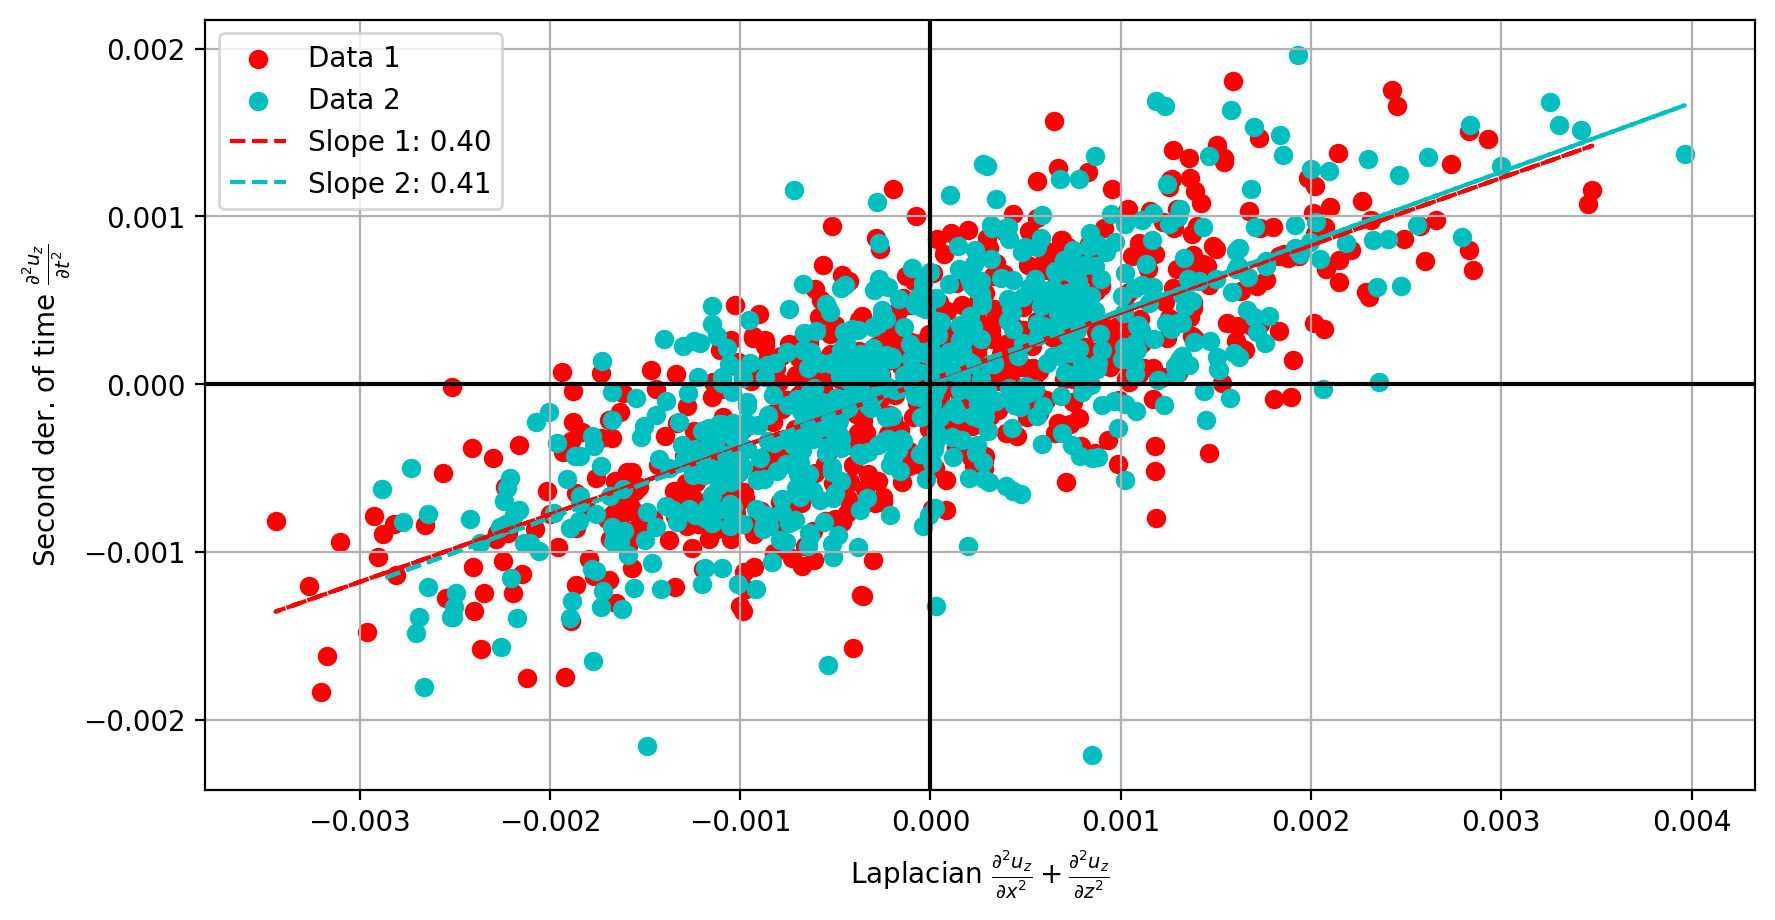

In [45]:
# Extracting the specific data points for plotting and linear regression
x1, y1 = sd_space[:, *_centerpoint], sd_time[:, *_centerpoint]
x2, y2 = sd_space[:, *_rightpoint], sd_time[:, *_rightpoint]

# Performing linear regression to estimate the slopes
slope1, intercept1, _, _, _ = linregress(x1, y1)
slope2, intercept2, _, _, _ = linregress(x2, y2)

plt.figure(figsize=(10, 5),dpi=200)

# Plotting the scatter plots
plt.scatter(x1, y1, c='r', label='Data 1')
plt.scatter(x2, y2, c='c', label='Data 2')

# Plotting the regression lines
plt.plot(x1, intercept1 + slope1 * x1, 'r--', label=f'Slope 1: {slope1:.2f}')
plt.plot(x2, intercept2 + slope2 * x2, 'c--', label=f'Slope 2: {slope2:.2f}')

# # Plotting the regression lines
# plt.plot(x1, intercept1 + np.sum(y1/x1)/sd_time.shape[0] * x1, 'k', label=f'Quotient Slope 1: {np.sum(y1/x1)/sd_time.shape[0]:.2f}')
# plt.plot(x2, intercept2 + np.sum(y2/x2)/sd_time.shape[0] * x2, 'k', label=f'Quotient Slope 2: {np.sum(y2/x2)/sd_time.shape[0]:.2f}')

plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.grid(True)
plt.xlabel(r'Laplacian $\frac{\partial^2 u_z}{\partial x^2}+\frac{\partial^2 u_z}{\partial z^2}$')
plt.ylabel(r'Second der. of time $\frac{\partial^2 u_z}{\partial t^2}$')

plt.legend()
plt.show()


# Gradiometry based inversion
Now we try to solve the inverse problem given by:

$$
\Delta M_0(x,z)D_\Delta U_z^i = \ddot{U}^i - \bar{M_0}D_\Delta U_z^i
$$

Where $M_0(x,z) = c_s^2(x,z) = \mu(x,z)/\rho$ (assuming density constant as done in medical) is the shear wave velocity. We state the shear wave velocity as the result of a perturbation on an average constant background value, $M_0(x,z) = \bar{M_0} + \Delta M_0(x,z)$. $U^i$ is a vector containing the vertical displacement observations for all the points in the 2D section for the ith time sample, and $D_\Delta$ denotes a discrete Laplace operator to obtain spatial derivatives for all elements of $U^i$. $\ddot{U}$ denotes the second order derivative in time. The wave equation then has the form $F_i m = b_i$ where i denotes a specific wavefield state observed at a different time. Then, writing:
$$
F_i = \text{diag}\{ D_\Delta U_z^i \}
$$

$$
\vec{b_i} = \ddot{U}^i - \bar{M_0}D_\Delta U_z^i
$$

$$
\vec{m}=\Delta M_0
$$

Where diag{} denotes a diagonal matrix formed with the input vector on the diagonal. $F_i$ is a matrix of size $M\times M$, where $M=m\times n$ is the number of model parameters equating to the total number of points on the 2D section given by m horizontal by n vertical units. 

This problem is solved by doing:

$$\left[ \sum_{i=1}^N F_i^TF_i + \text{regularizer} \right] m = \sum^N_{i=1} F_ib_i$$

For a single time sample we have the following:

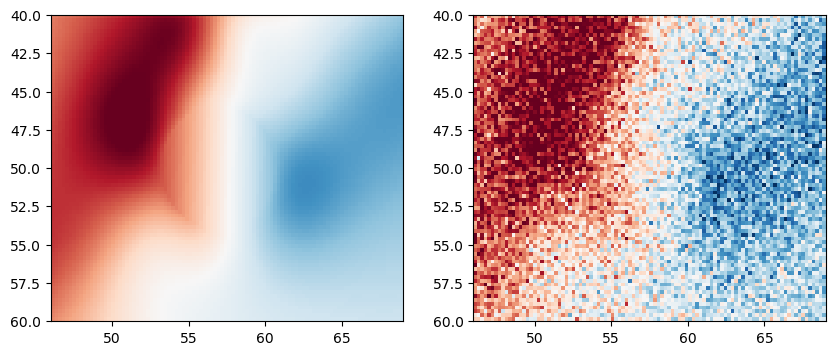

In [46]:
divnorm = colors.TwoSlopeNorm(vmin=-0.2/44, vcenter=0, vmax=0.2/44)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(d[100, :, :].T, extent=[receiver_positions.min(), receiver_positions.max(), 60, 40], norm=divnorm, interpolation='none', cmap='RdBu_r', aspect='equal')
axs[1].imshow(dn[100, :, :].T, extent=[receiver_positions.min(), receiver_positions.max(), 60, 40], norm=divnorm, interpolation='none', cmap='RdBu_r', aspect='equal')

In [47]:
#Uz = disp_z[120:, int(45/dx):int(70/dx):1, :int(20/dx):1]
#Uz = cumsum_in_windows(disp_z[120:, int(45/dx):int(70/dx):4, :int(20/dx):2], 20)
#Uz = matrix_time[:, :, :]
Uz = d

nt, nx, nz = Uz.shape
Uz0 = Uz[10, :, :]

In [50]:
Dop = pylops.Laplacian(dims=(nx, nz), order=4)
F0 = pylops.Diagonal(Dop * Uz0.ravel())

SDop = pylops.SecondDerivative(dims=(nt, nx, nz), axis=0)
_b0 = SDop * Uz.ravel()
M0back = np.ones(nx*nz) * 128
b0 = _b0[:nx*nz] - M0back * (Dop * Uz0.ravel())

mest, *rest  = pylops.optimization.leastsquares.normal_equations_inversion(F0, b0, None)

TypeError: Laplacian.__init__() got an unexpected keyword argument 'order'

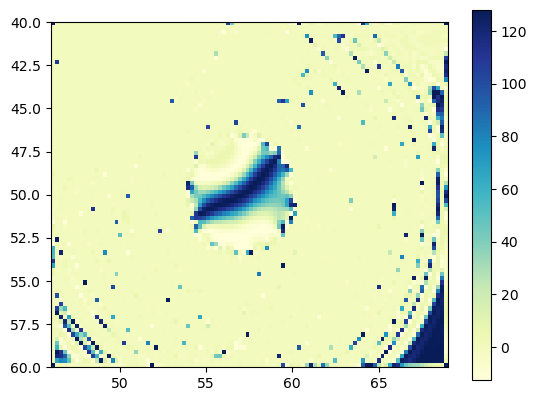

In [49]:
plt.imshow((mest+M0back).reshape(nx, nz).T, cmap='YlGnBu', extent=[receiver_positions.min(), receiver_positions.max(), 60, 40])
plt.colorbar()

## Solving for all times

$$\left[ \sum_{i=1}^N F_i^TF_i + \epsilon_1 D_\Delta^T D_\Delta + \epsilon_2 I \right] m = \sum^N_{i=1} F_ib_i$$

In [415]:
# Define necessary variables for constructing Fi and bi for each time sample
nt, nx, nz = Uz.shape
M = nx * nz  # Total number of model parameters
dt = dtsnap

LHS_accumulator = pylops.Zero(*(M, M))
RHS_accumulator = np.zeros(M)

M0back = np.ones(M) * 128

# Laplacian Operator
Dop = pylops.Laplacian(dims=(nx, nz))

Iop = pylops.Identity((nx*nz))

# Iterate over each time sample to accumulate Fi^T*Fi and Fi*bi
for i in range(nt):
    Uzi = Uz[i, :, :].ravel()  # Current time sample
    F = pylops.Diagonal(Dop * Uzi)  # Construct Fi
    
    # Second derivative in time for current time sample
    dUdt2 = (Uz[min(i+1, nt-1), :, :] - 2*Uz[i, :, :] + Uz[max(i-1, 0), :, :]).ravel() / dt**2
    
    # Construct bi for current time sample
    bi = dUdt2 - M0back * (Dop * Uzi)
    
    # Accumulate Fi^T*Fi and Fi*bi
    LHS_accumulator += F 
    RHS_accumulator += bi 

#epsRs=[5e-5, 3e-5]
#epsRs = [0, 0]
#epRs = [10, 1e-2]
#epsRs=[5e-2, 1e-3]

# Solve the linear equation
mest, *rest  = pylops.optimization.leastsquares.normal_equations_inversion(LHS_accumulator, RHS_accumulator, [Dop, Iop], epsRs=epsRs, **dict(maxiter=1500))

[0]

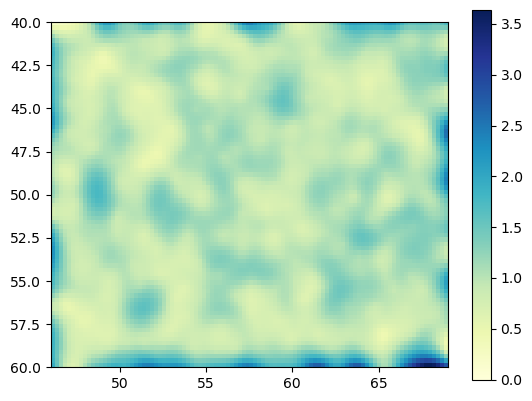

In [416]:
plt.imshow((mest + M0back).reshape(nx, nz).T, cmap='YlGnBu', vmin=0, extent=[receiver_positions.min(), receiver_positions.max(), 60, 40], interpolation='none')
plt.colorbar()

# Simulation of experiment

In [180]:
central_frequency = 12000  # Hz
sampling_rate = 20000  # Hz
duration = 0.09  # Seconds
points = int(duration * sampling_rate)
speed_of_sound = 1500  # m/s
np.random.seed(0)

# Assuming other parameters (central_frequency, sampling_rate, etc.) are defined as before
num_time_steps = len(scatterer_history[0])  # Assuming this is defined as before

# Generate Ricker wavelet
wavelet = ricker(points, (central_frequency / sampling_rate) * np.pi * 2)

def simulate_signals(scatterer_history, receiver_positions, beamwidth, dx, num_receivers, num_time_steps, scatterer_amplitudes):
    signals_time_steps = np.zeros((num_receivers, num_time_steps, points))

    for frame in range(num_time_steps):
        for i, pos in enumerate(receiver_positions):
            signals_frame = np.zeros(points)
            
            # Retrieve scatterers' positions for this frame
            scatterers_frame = np.array([scatterer_history[sc][frame] for sc in range(num_scatterers)])
            
            # Filter scatterers within the beamwidth of the current receiver and use fixed amplitudes
            for scatterer_index, scatterer in enumerate(scatterers_frame):
                if pos - beamwidth/2 <= scatterer[0]*dx <= pos + beamwidth/2:
                    depth = scatterer[1] * dx
                    spike_time = int(((2 * (depth+40)) / speed_of_sound) * sampling_rate)
                    if spike_time < points:
                        signals_frame[spike_time] += scatterer_amplitudes[scatterer_index]  # Use fixed amplitude

            # Convolve signal with Ricker wavelet
            signals_time_steps[i, frame, :] = convolve(signals_frame, wavelet, mode='same')

    return signals_time_steps

# Simulate and plot signals with fixed amplitudes
sigs = simulate_signals(scatterer_history, receiver_positions, beamwidth, dx, num_receivers, num_time_steps, scatterer_amplitudes)

/tmp/ipykernel_220719/1156113470.py:12: DeprecationWarning: scipy.signal.ricker is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  wavelet = ricker(points, (central_frequency / sampling_rate) * np.pi * 2)


In [181]:
def windowed_cross_correlation(signal1, signal2, window_length, sampling_rate = sampling_rate, speed_of_sound = speed_of_sound):

    srl = window_length * 2  # seconds

    window_samples = int(window_length * sampling_rate)
    search_region_samples = int(srl * sampling_rate)

    displacements = []
    times = []

    for i in range(window_samples // 2, len(signal2) - window_samples // 2, window_samples // 4):
        times.append(i)

        window = signal2[i - window_samples // 2: i + window_samples // 2]
        search_region = signal1[max(i - search_region_samples // 2, 0): i + search_region_samples // 2]

        if np.all(window == 0) or np.all(search_region == 0):
            displacements.append(0)
        
        else:
            correlation = correlate(search_region, window, mode='full')

            if correlation.max() > 1e-1:
                sorted_idx = np.argsort(correlation)
                top3 = sorted_idx[-5:]

                if np.abs(top3[-1] - ((len(search_region) + len(window)) // 2 - 1)) <= 10:
                    peak_index = top3[-1]
                
                elif np.abs(top3[-2] - ((len(search_region) + len(window)) // 2 - 1)) <= 10:
                    peak_index = top3[-2]

                else:
                    displacements.append(np.nan)
                    continue

                num_points = 3  # Points on each side of the peak for fitting
                fit_indices = np.arange(max(0, peak_index - num_points), min(peak_index + num_points + 1, len(correlation)))
                fit_values = correlation[fit_indices]

                fit_coeffs = np.polyfit(fit_indices, fit_values, 2)
                vertex_index = -fit_coeffs[1] / (2 * fit_coeffs[0])

                shift_samples = vertex_index - ((len(search_region) + len(window)) // 2 - 1)
                refined_dt = shift_samples / sampling_rate
                displacement = (shift_samples / sampling_rate) * speed_of_sound / 2

                displacements.append(displacement)

                if np.abs(shift_samples) > 30:

                    print(top3, np.argmax(correlation))

                    fig, axs = plt.subplots(3, 1, figsize=(10, 8))

                    axs[0].plot(np.linspace(i - window_samples // 2, i + window_samples // 2, len(window)), window, label='Window')
                    axs[0].plot(np.linspace(i - search_region_samples // 2, i + search_region_samples // 2, len(search_region)), search_region, label='Search Region')
                    axs[0].legend()

                    axs[1].plot(correlation, 'k--', marker='o', label='Correlation')
                    axs[1].axvline(peak_index, color='blue', label='Peak Index')
                    axs[1].set_xlim(peak_index - 10*num_points, peak_index + 10*num_points)
                    axs[1].scatter(fit_indices, fit_values, color='red', zorder=5, label='Fit Points')

                    # Plotting the fitted parabola
                    dense_fit_indices = np.linspace(fit_indices[0], fit_indices[-1], num=100)
                    parabola_values = np.polyval(fit_coeffs, dense_fit_indices)
                    axs[1].plot(dense_fit_indices, parabola_values, 'g-', label='Fitted Parabola')
                    axs[1].legend()

                    axs[2].plot(np.linspace(i - window_samples//2, i+window_samples//2, len(window))+shift_samples, window)
                    axs[2].plot(np.linspace(i - search_region_samples//2, i+search_region_samples//2, len(search_region)), search_region)

                    plt.show()

            else:
                displacements.append(np.nan)

    # Convert the list to a NumPy array if it isn't one already
    displacements_array = np.array(displacements)
    non_nan_indices = np.where(~np.isnan(displacements_array))[0]
    nan_indices = np.where(np.isnan(displacements_array))[0]
    displacements_array[nan_indices] = np.interp(nan_indices, non_nan_indices, displacements_array[non_nan_indices])

    return times, displacements_array

(40.0, 60.0)

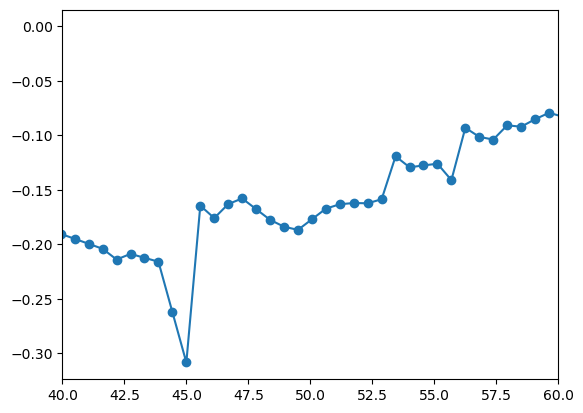

In [182]:
times, displacements_array = windowed_cross_correlation(sigs[0, 100, :], sigs[0, 200, :], 0.003)

plt.plot((np.array(times)/sampling_rate)*(speed_of_sound/2), displacements_array, marker='o')
plt.xlim(40, 60)

In [183]:
def estimate_displacements_for_all_receivers(sigs, interval, wl = 0.003, dt = dtsnap):
    """
    Estimates displacements for all receivers and returns a matrix with dimensions [time, x, y].
    :param sigs: Signal array with dimensions [receiver, time, sample].
    :param time_step1: The first time step to compare.
    :param time_step2: The second time step to compare.
    :return: 3D matrix of displacements with dimensions [time, x, y].
    """
    num_receivers = sigs.shape[0]

    matrix_time = []
    times = np.arange(0, 500, interval)

    for t in times:
    
        displacements_list = []

        for receiver_index in range(num_receivers):
            signal1 = sigs[receiver_index, t, :]
            signal2 = sigs[receiver_index, t + interval, :]
            _t, displacements = windowed_cross_correlation(signal1, signal2, wl)
            displacements_list.append(displacements) 

        matrix_time.append(np.vstack(displacements_list))

    return times*dt, np.array(matrix_time), _t

In [184]:
timess, matrix_time, _t = estimate_displacements_for_all_receivers(sigs, 20, wl = 0.003)  # wl = 0.0018
matrix_time = matrix_time[:, :, np.where((np.array(_t)/sampling_rate)*(speed_of_sound/2)>40)[0][0]-1: np.where((np.array(_t)/sampling_rate)*(speed_of_sound/2)<60)[0][-1]]

#matrix_time.shape, len(_t), np.where((np.array(_t)/sampling_rate)*(speed_of_sound/2)>40)[0][0],  np.where((np.array(_t)/sampling_rate)*(speed_of_sound/2)<60)[0][-1]

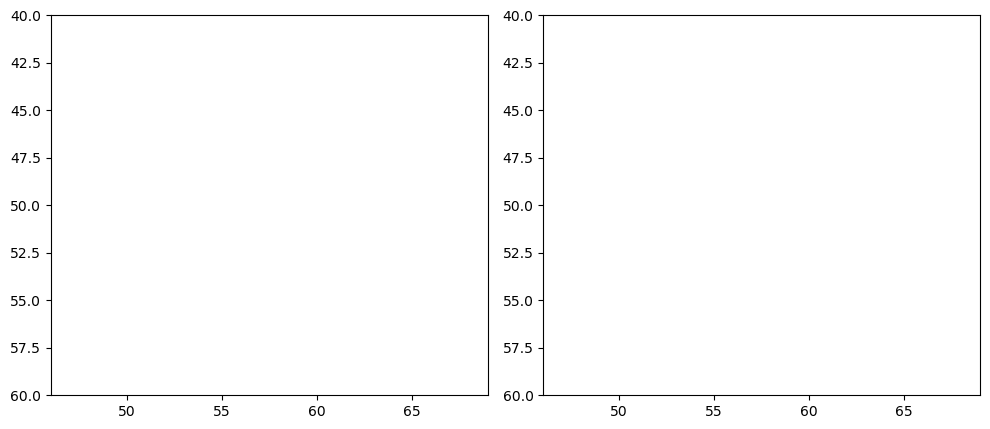

In [252]:
from matplotlib import colors

clip = 3
divnorm = colors.TwoSlopeNorm(vmin=-0.2/clip, vcenter=0, vmax=0.2/clip)

theoretical = -cumsum_in_windows(disp_z[:500, range(int(45/dx), int(70/dx), 4), :int(20/dx):2], 20)

# Genearte noise with same shape as that of the image
noise = np.random.normal(0, 1e-3, theoretical.shape) 

noisy = theoretical + noise

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
camera = Camera(fig)

for t in range(matrix_time.shape[0]):
    axs[0].imshow(noisy[t, :, :].T, extent=[receiver_positions.min(), receiver_positions.max(), 60, 40], norm=divnorm, interpolation='none', cmap='RdBu_r', aspect='equal')
    axs[1].imshow(matrix_time[t, :, :].T, extent=[receiver_positions.min(), receiver_positions.max(), 60, 40], norm=divnorm, interpolation='none', cmap='RdBu_r', aspect='equal')
    plt.tight_layout()

    camera.snap()

animation = camera.animate(interval = 200)
animation.save('video.mp4')

In [192]:
matrix_time.shape, cumsum_in_windows(disp_z[:500, range(int(45/dx), int(70/dx), 4), :int(20/dx):2], 20).shape

((25, 20, 35), (25, 25, 40))

(-0.08, 0.08)

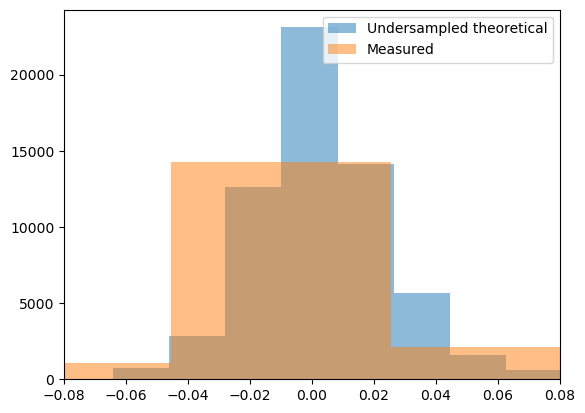

In [199]:
plt.hist(cumsum_in_windows(disp_z[200:, int(45/dx):int(70/dx):4, :int(20/dx)], 20).flatten(), density=False, alpha=0.5, label='Undersampled theoretical')
plt.hist(matrix_time.flatten(), density=False, alpha=0.5, label='Measured')

plt.legend()
plt.xlim(-0.08, 0.08)